In [1]:
import os,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
spam_data = pd.read_csv('../data/spam.csv',encoding='ISO-8859-1')
# spam_data.head()
spam_data['labels'] = spam_data['v1'].map({'ham':0,'spam':1})
spam_data = spam_data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4','v1'],axis=1)
spam_data.columns = ['text','labels']
print(spam_data.shape)
spam_data.head()

(5572, 2)


,text,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [3]:
spam_data.to_csv('spam_data.csv',index = False)

In [4]:
import torchtext.data as ttd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [5]:
TEXT = ttd.Field(sequential = True,batch_first = True,lower = True,pad_first = True)
LABEL = ttd.Field(sequential = False,use_vocab=False,is_target = True)

In [6]:
dataset = ttd.TabularDataset(
    path = 'spam_data.csv',
    format = 'csv',
    skip_header = True,
    fields = [('text',TEXT),('labels',LABEL)]
)

In [7]:
for text in dataset.examples[:5]:
    print(text.text,text.labels)
    print(len(text.text))

['go', 'until', 'jurong', 'point,', 'crazy..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet...', 'cine', 'there', 'got', 'amore', 'wat...'] 0
20
['ok', 'lar...', 'joking', 'wif', 'u', 'oni...'] 0
6
['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005.', 'text', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'question(std', 'txt', "rate)t&c's", 'apply', "08452810075over18's"] 1
28
['u', 'dun', 'say', 'so', 'early', 'hor...', 'u', 'c', 'already', 'then', 'say...'] 0
11
['nah', 'i', "don't", 'think', 'he', 'goes', 'to', 'usf,', 'he', 'lives', 'around', 'here', 'though'] 0
13


In [8]:
train_data,test_data = dataset.split(0.8)
print(len(train_data),len(test_data))

4458 1114


In [9]:
TEXT.build_vocab(train_data)
vocab = TEXT.vocab
stoi = vocab.stoi
itos = vocab.itos

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 32
EMBED_DIM = 50
N_OUTPUT = 1 # spam or ham
print(DEVICE)

cuda


In [11]:
train_iter,test_iter = ttd.Iterator.splits(
    (train_data,test_data),
    sort_key=lambda x: len(x.text),
    batch_sizes = (TRAIN_BATCH_SIZE,TEST_BATCH_SIZE),
    device = DEVICE
)

In [12]:
for data,target in train_iter:
    print(data.shape,target.shape)
    break

torch.Size([64, 55]) torch.Size([64])


In [13]:
## CUSTOM CNN MODEL
class CustomCNN(nn.Module):
    def __init__(self,n_vocab,embed_dim,n_output):
        super(CustomCNN,self).__init__()
        self.V = n_vocab
        self.embed_dim = embed_dim
        self.K = n_output
        
        ## embedding layer
        self.embed_layer = nn.Embedding(self.V,self.embed_dim)
        
        ## conv layers
        self.conv1 = nn.Conv1d(self.embed_dim,32,3,padding = 1)
        self.pool1 = nn.MaxPool1d(1)
        self.conv2 = nn.Conv1d(32,64,3,padding = 1)
        self.pool2 = nn.MaxPool1d(1)
        self.conv3 = nn.Conv1d(64,128,3,padding = 1)
        self.pool3 = nn.MaxPool1d(1)
        
        ## dense layers
        self.fc = nn.Linear(128,self.K)
        
    def forward(self,X):
        # X -> NxT torch tensor
        out = self.embed_layer(X) # out -> NxTxD
        
        # permute to make features first for convs
        out = out.permute(0,2,1)
        out = self.conv1(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = self.pool3(out)
        
        out = out.permute(0,2,1) # permute to make features last
        out,_ = torch.max(out,1)
        
        out = self.fc(out)
        return out

In [14]:
cnn_model = CustomCNN(len(vocab),EMBED_DIM,N_OUTPUT).to(DEVICE)

In [15]:
print(train_iter,test_iter)
print(cnn_model)

<torchtext.data.iterator.Iterator object at 0x7f70fa5c1908> <torchtext.data.iterator.Iterator object at 0x7f70fa5c1940>
CustomCNN(
  (embed_layer): Embedding(11681, 50)
  (conv1): Conv1d(50, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(cnn_model.parameters())

In [17]:
def train_model(model,criterion,optim,train_data,test_data,n_epochs):
    train_loss_arr = np.zeros(n_epochs)
    test_loss_arr = np.zeros(n_epochs)
    for epoch in range(n_epochs):
        train_losses = []
        for data,target in train_iter:
#             print(data.shape)
            target = target.view(-1,1).float()
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out,target)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
#             print(loss.item())
        train_loss_arr[epoch] = np.mean(train_losses)
        
        test_losses = []
        for data,target in test_iter:
            target = target.view(-1,1).float()
            out = model(data)
            loss = criterion(out,target)
            
            test_losses.append(loss.item())
#         print(np.mean(test_losses))
        test_loss_arr[epoch] = np.mean(test_losses)
        
        print(f'Epoch : {epoch}\ttrain_loss : {train_loss_arr[epoch]}\ttest loss : {test_loss_arr[epoch]}')
        
    return train_loss_arr,test_loss_arr

In [18]:
train_loss,test_loss = train_model(cnn_model,criterion,optimizer,train_iter,test_iter,20)

Epoch : 0	train_loss : 0.3954566221152033	test loss : 0.3991402479154723
Epoch : 1	train_loss : 0.32196312546730044	test loss : 0.3648718280451638
Epoch : 2	train_loss : 0.19561385358018535	test loss : 0.3993092632719449
Epoch : 3	train_loss : 0.09193435055868966	test loss : 0.46620464410100665
Epoch : 4	train_loss : 0.048834680626168844	test loss : 0.535700713310923
Epoch : 5	train_loss : 0.024937043871198383	test loss : 0.5097161080156054
Epoch : 6	train_loss : 0.012991077775534774	test loss : 0.6255449618612017
Epoch : 7	train_loss : 0.004582116891729778	test loss : 0.735937591109957
Epoch : 8	train_loss : 0.002525021668822904	test loss : 0.7591059399502618
Epoch : 9	train_loss : 0.0010553980132889202	test loss : 0.7385927719729287
Epoch : 10	train_loss : 0.0005146251399440059	test loss : 0.845421188218253
Epoch : 11	train_loss : 0.00034985397983941117	test loss : 0.8576147649969373
Epoch : 12	train_loss : 0.0002600300847136948	test loss : 0.874773935335023
Epoch : 13	train_loss : 0

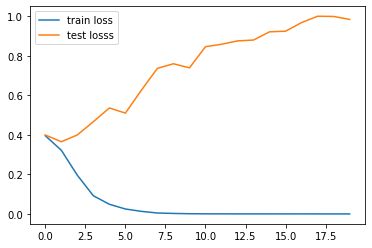

In [19]:
plt.plot(train_loss,label = 'train loss')
plt.plot(test_loss, label = 'test losss')
plt.legend()

In [35]:
print('Compute accuracies')
## train accuracies

with torch.no_grad():
    n_total,n_correct = 0,0
    for data,target in train_iter:
        out = cnn_model(data)
        preds = (out > 0).view(-1)
#         print(preds,target)
        n_correct += (preds == target).sum().item()
        n_total += target.shape[0]
    print(n_correct,n_total)
    train_acc = n_correct / n_total
    
    print('training accuracy : {:.6f}'.format(train_acc))
    n_total,n_correct = 0,0
    y_test,p_test = [],[]
    for data,target in test_iter:
        out = cnn_model(data)
        preds = (out > 0).view(-1)
        p_test += list(preds.to('cpu').numpy())
        y_test += list(target.to('cpu').numpy())
        n_correct += (preds == target).sum().item()
        n_total += target.shape[0]
    test_acc = n_correct / n_total
    print('Testing accuracy : {:.4f}'.format(test_acc))

Compute accuracies
4458 4458
training accuracy : 1.000000
Testing accuracy : 0.8465


In [36]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [37]:
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
[[785 164]
 [  7 158]]


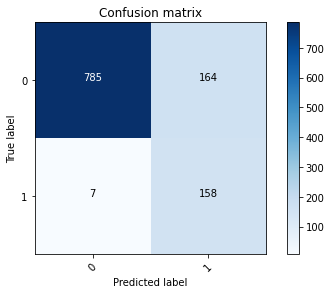

In [38]:
cm = confusion_matrix(y_test,p_test)
plot_confusion_matrix(cm,[0,1])
# print(len(y_test),len(p_test))

In [39]:
spam_data.head()

,text,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [55]:
temp_data = spam_data[spam_data.labels == 1].sample(3)
with open('predict_test.csv','w') as f:
    f.write('data\n')
    for line in temp_data['text'].values:
        print(line)
        f.write(line + '\n')

4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths ? Call MobilesDirect free on 08000938767 to update now! or2stoptxt
FreeMsg: Hey - I'm Buffy. 25 and love to satisfy men. Home alone feeling randy. Reply 2 C my PIX! QlynnBV Help08700621170150p a msg Send stop to stop txts
December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906


In [53]:
test_table = ttd.TabularDataset(
    path = 'predict_test.csv',
    format = 'csv',
    skip_header = True,
    fields = [('data',TEXT)]
)

test_iterator = ttd.Iterator(
    test_table,
    sort_key = lambda x : len(x.data),
    batch_size = 32,
    device  = DEVICE
)

In [58]:
for data in test_iterator:
    print(data)
    out = cnn_model(data.data)
    print(out)


[torchtext.data.batch.Batch of size 3]
	[.data]:[torch.cuda.LongTensor of size 3x24 (GPU 0)]
tensor([[12.9949],
        [10.8043],
        [14.3790]], device='cuda:0', grad_fn=<AddmmBackward>)


In [66]:
## prediting from single sentence
single_sent = spam_data['text'].sample(1).values[0]
print(single_sent)

Good evening Sir, hope you are having a nice day. I wanted to bring it to your notice that I have been late in paying rent for the past few months and have had to pay a $ &lt;#&gt;  charge. I felt it would be inconsiderate of me to nag about something you give at great cost to yourself and that's why i didnt speak up. I however am in a recession and wont be able to pay the charge this month hence my askin well ahead of month's end. Can you please help. Thank you for everything.


In [70]:
toks = TEXT.preprocess(single_sent)
sent_idx = TEXT.numericalize([toks])
cnn_model(sent_idx.to(DEVICE))

tensor([[-14.9448]], device='cuda:0', grad_fn=<AddmmBackward>)